# 9 - Visualizing Aggregates

This tutorial brings together concepts from previous posts around data visualization, statpoints, and windows queries. The visualizations provided below offer a powerful tool for visualizing arbitrarily long time series of data, while also highlighting specific regions in the data that may be of interest.

We also provide two helper functions which may be useful for other user-developed code. The first (`points_to_dataframe`) takes a list of StatPoint objects returned from a btrdb windows queries and converts it into a Pandas dataframe, where the columns are StatPoint attributes (i.e., min, max, mean, standard deviation and count). The second helper function (`plot_aggregates`) uses this Pandas dataframe to generate a plot showing the range and distribution of values over time.

In [1]:
import btrdb
import pandas as pd
import numpy as np

import time


from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from btrdb.utils import timez

db = btrdb.connect()

### Select data

In [2]:
streams = db.streams_in_collection('sunshine/PMU1', tags={'unit': 'volts'})

pd.DataFrame([[s.name, s.unit, s.collection] for s in streams],
            columns=['name','unit','collection'])

,name,unit,collection
0,L3MAG,volts,sunshine/PMU1
1,L1MAG,volts,sunshine/PMU1
2,L2MAG,volts,sunshine/PMU1


### Determine time interval

Below, we use `stream.earliest()` and `stream.latest()` to determine the time interval spanned by the data.

In [3]:
stream = db.stream_from_uuid(streams[1].uuid)

def get_time(stream, func):
    return timez.ns_to_datetime(getattr(stream, func)()[0].time)

print('start:', get_time(streams[0], 'earliest'))
print('end:', get_time(streams[0], 'latest'))
print(str(get_time(streams[0], 'latest') - get_time(streams[0], 'earliest')))

start: 2015-10-01 16:08:24.008333+00:00
end: 2017-04-15 01:41:35.999999+00:00
561 days, 9:33:11.991666


See it in the plotter: https://plot.ni4ai.org/permalink/VKne4LTTl

### Choose time interval

Here, we select a time interval of one year.

In [4]:
start_time = datetime(2016,4,1)
end_time = datetime(2017,4,1)

start_ns = timez.datetime_to_ns(start_time)
end_ns = timez.datetime_to_ns(end_time)

https://plot.ni4ai.org/permalink/2KN5iCXw5

In [5]:
window = timez.ns_delta(days=30)
pw = int(np.log2(window))

points, _ = zip(*stream.aligned_windows(start_ns, end_ns, pointwidth=pw))
points

(StatPoint(1459166279268040704, 6825.37109375, 7157.580867829119, 7301.88525390625, 269591739, 36.51418677591111),
 StatPoint(1461418079081725952, 6580.9541015625, 7161.23304578515, 7300.8623046875, 269692154, 35.61453444076186),
 StatPoint(1463669878895411200, 6796.833984375, 7160.458736401789, 7286.55126953125, 147383982, 34.1646855496053),
 StatPoint(1465921678709096448, 6964.91455078125, 7159.378036144785, 7325.37158203125, 206497053, 40.14920297145494),
 StatPoint(1468173478522781696, 5558.57421875, 7167.452925690963, 7294.76318359375, 269810992, 39.238088874956624),
 StatPoint(1470425278336466944, 5780.056640625, 7161.174368865373, 7307.212890625, 268549058, 41.321696619794494),
 StatPoint(1472677078150152192, 6392.52099609375, 7161.894405845441, 7318.228515625, 268988146, 39.96141042153979),
 StatPoint(1474928877963837440, 5955.3212890625, 7158.670968887105, 7300.72509765625, 255962541, 39.97700500308349),
 StatPoint(1477180677777522688, 5097.31298828125, 7156.974233908252, 7283

## Convert to pandas dataframe

In [6]:
def points_to_dataframe(points, 
                        aggregates=['time','min','max','mean','stddev','count'],
                        use_datetime_index=True):
    df = pd.DataFrame([[getattr(p, agg) for agg in aggregates] for p in points],
                         columns=aggregates)
    if use_datetime_index:
        df['datetime'] = [timez.ns_to_datetime(t) for t in df.time]
        df = df.set_index('datetime')
    return df

df = points_to_dataframe(points)
df

,time,min,max,mean,stddev,count
datetime,,,,,,
2016-03-28 11:57:59.268041+00:00,1459166279268040704,6825.371094,7301.885254,7157.580868,36.514187,269591739
2016-04-23 13:27:59.081726+00:00,1461418079081725952,6580.954102,7300.862305,7161.233046,35.614534,269692154
2016-05-19 14:57:58.895411+00:00,1463669878895411200,6796.833984,7286.551270,7160.458736,34.164686,147383982
2016-06-14 16:27:58.709096+00:00,1465921678709096448,6964.914551,7325.371582,7159.378036,40.149203,206497053
2016-07-10 17:57:58.522782+00:00,1468173478522781696,5558.574219,7294.763184,7167.452926,39.238089,269810992
2016-08-05 19:27:58.336467+00:00,1470425278336466944,5780.056641,7307.212891,7161.174369,41.321697,268549058
2016-08-31 20:57:58.150152+00:00,1472677078150152192,6392.520996,7318.228516,7161.894406,39.961410,268988146
2016-09-26 22:27:57.963837+00:00,1474928877963837440,5955.321289,7300.725098,7158.670969,39.977005,255962541
2016-10-22 23:57:57.777523+00:00,1477180677777522688,5097.312988,7283.453613,7156.974234,36.330541,268787149


## Define data viz helper function

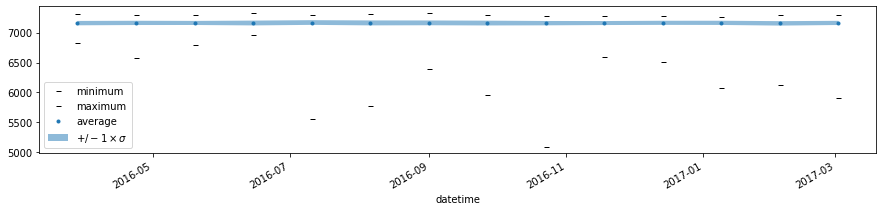

In [7]:
def plot_aggregates(df, vlines=[], hlines=[]):
    fig, ax = plt.subplots(figsize=(15,3))
    df['min'].plot(ax=ax, ls=' ', marker='_', color='black', markersize=5, label='minimum')
    df['max'].plot(ax=ax, ls=' ', marker='_', color='black', markersize=5, label='maximum')
    df['mean'].plot(ax=ax, label='average', ls=' ', marker='.')
    ax.fill_between(df.index, df['mean']-df['stddev'], df['mean'] + df['stddev'], alpha=0.5, label=r'$+/- 1\times\sigma$')
    plt.legend()

    ax.vlines(vlines, *ax.get_ylim(), color='0.5', alpha=0.5, zorder=10, lw=3, label='events')
    ax.hlines(hlines, *ax.get_xlim(), color='0.5', zorder=10, lw=1, ls='--', label='threshold')
    return fig
    
plot_aggregates(df)
plt.show()

## Visualize aggregates at different time-resolutions

### Weekly

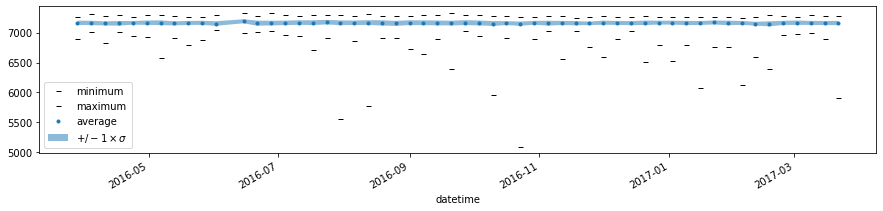

In [8]:
window = timez.ns_delta(days=7)
pw = int(np.log2(window))

points, _ = zip(*stream.aligned_windows(start_ns, end_ns, pointwidth=pw))
df = points_to_dataframe(points)
fig = plot_aggregates(df)

### Daily

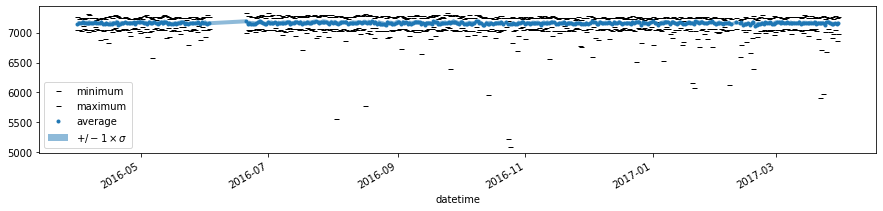

In [9]:
window = timez.ns_delta(days=1)
pw = int(np.log2(window))

points, _ = zip(*stream.aligned_windows(start_ns, end_ns, pointwidth=pw))
df = points_to_dataframe(points)
fig = plot_aggregates(df)